In [4]:
import os
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, BatchNormalization, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow_probability import distributions as tfd
from sklearn.metrics import mean_absolute_error, mean_squared_error

from utils import *
from constants import *

## Display Results

## Display Results

In [5]:
results = pd.read_csv('results.csv')

# Print results
for idx, row in results.iterrows():
    print("Model:", row['Model Name'])
    for metric, value in row.items():
        if metric != 'Model Name':
            print(f"{metric:50} {value if isinstance(value, str) else round(value, 2)}")
    print("\n")

Model: Non-probabilistic MLP
Train RMSE                                         27.43
Train MAE                                          16.39
Test RMSE                                          27.97
Test MAE                                           16.68
Test % within 99.00% CI                            96.22726192676294


Model: Epistemic Uncertainty BNN (Flipout) - 1.0% Sample
Train RMSE                                         124.99
Train MAE                                          92.54
Test RMSE                                          124.93
Test MAE                                           92.37
Test % within 99.00% CI                            17.168730364073184


Model: Epistemic Uncertainty BNN (Flipout)
Train RMSE                                         29.38
Train MAE                                          18.14
Test RMSE                                          29.74
Test MAE                                           18.25
Test % within 99.00% CI                   

In [6]:
# Format results to be added to a latex table.

results = pd.read_csv('results.csv')

metrics = results.columns[1:]

for idx, row in results.iterrows():
    formatted_line = ""
    for i, metric in enumerate(metrics):
        value = row[metric]
        # Try converting string values to floats
        try:
            value = float(value)
        except ValueError:
            pass 
        # Format the value to two decimal places
        formatted_value = "{:.2f}".format(value) if isinstance(value, float) else value
        if i == len(metrics) - 1:
            formatted_value += "\%" 
        
        formatted_line += f" & {formatted_value}"
        if i == 0:
            formatted_line = str(row['Model Name']) + " " + formatted_value
    print(formatted_line + " \\\\")
    print("\n")

Non-probabilistic MLP 27.43 & 16.39 & 27.97 & 16.68 & 96.23\% \\


Epistemic Uncertainty BNN (Flipout) - 1.0% Sample 124.99 & 92.54 & 124.93 & 92.37 & 17.17\% \\


Epistemic Uncertainty BNN (Flipout) 29.38 & 18.14 & 29.74 & 18.25 & 25.59\% \\


Stochastic Output BNN (Flipout) 569.53 & 368.60 & 569.11 & 367.50 & 7.82\% \\


Probabilistic MLP (Separate Sub-models) 49.15 & 30.16 & 49.05 & 30.07 & 93.31\% \\


Probabilistic MLP (Joint Sub-models) 67.34 & 41.09 & 66.86 & 40.81 & 98.02\% \\


Probabilistic CNN with Gaussian Output 271.13 & 192.23 & 270.53 & 192.03 & 99.92\% \\


Non-Bayesian Multivariate (Only Diagonal) 237.36 & 173.29 & 237.74 & 174.52 & 88.11\% \\


Probabilistic Multivariate MLP (Only Diagonal) 426.07 & 295.08 & 430.43 & 299.52 & 11.94\% \\


Probabilistic Multivariate MLP (Lower Triangular Covariance Matrix) 943.51 & 687.71 & 955.25 & 699.34 & 2.50\% \\


GP (RBF, only-wind) 65.46 & 46.60 & 68.85 & 46.52 & -\% \\


RBF 26.22 & 18.21 & 45.47 & 29.61 & -\% \\


Matern 13.4

## Additional Plots

In [7]:
DATA_PATH = "."

df_train = pd.read_pickle(open(DATA_PATH + '/cleaned_data_train.pkl','rb'))
df_test = pd.read_pickle(open(DATA_PATH + '/cleaned_data_test.pkl','rb'))

In [8]:
print("Full Training Set Size: ", df_train.shape[0])
print("Full Testing Set Size: ", df_test.shape[0])

df_train_single = df_train[df_train['turbine'] == TURBINE_ID]#.reset_index(drop=True, inplace=True)
df_test_single = df_test[df_test['turbine'] == TURBINE_ID]#.reset_index(drop=True, inplace=True)
df_train_single.reset_index(drop=True, inplace=True)
print("Turbine#{TURBINE_ID} Training Set Size: ", df_train.shape[0])
print("Turbine#{TURBINE_ID} Testing Set Size: ", df_test.shape[0])
df = pd.concat([df_train_single, df_test_single])

Full Training Set Size:  807764
Full Testing Set Size:  201943
Turbine#{TURBINE_ID} Training Set Size:  807764
Turbine#{TURBINE_ID} Testing Set Size:  201943


In [9]:
X_train, X_test, \
    y_train, y_test, \
    scaler = create_design_matrix(df_train_single, df_test_single, FEATURES, OUTPUT_FEATURE)

In [10]:
def plot_confidence_interval_bar_grid(y_test_pred_list, y_test_std_list, y_test_list, bins=20, rmses=None, titles=None, save_path=None):
    plt.rc('font', size=14)
    
    # Compute the t-values of the confidence intervals based on Z-scores
    t_values = np.array([stats.norm.ppf(i/bins + (1-i/bins)/2) for i in range(1, bins+1)])
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    for i, (y_test_pred, y_test_std, y_test) in enumerate(zip(y_test_pred_list, y_test_std_list, y_test_list)):
        percentages_within_interval = []
        for t_value in t_values:
            lower_bounds = y_test_pred.ravel() - t_value * y_test_std
            upper_bounds = y_test_pred.ravel() + t_value * y_test_std

            # Count number of data points within the confidence interval
            is_within_interval = np.logical_and(y_test >= lower_bounds, y_test <= upper_bounds)
            num_within_interval = np.sum(is_within_interval)

            # Calculate the percentage of data points within the confidence interval
            percentage_within_interval = (num_within_interval / len(y_test)) * 100
            percentages_within_interval.append(percentage_within_interval)

        row = i // 2
        col = i % 2

        bars = axes[row, col].bar(np.arange(1, bins+1)*100/bins, percentages_within_interval, color='#76b5c5', width=80/bins, edgecolor='black', alpha=0.9, label='Percentage of Residuals within Interval')
        axes[row, col].plot([0, 100], [0, 100], color='red', linestyle='--', label='Expected')
        
        # Calculate differences between the blue bars and the expected line
        expectations = np.arange(1, bins+1)*100/bins
        differences = np.array(percentages_within_interval) - expectations

        # Plot individual red bars for each discrepancy
        for j, difference in enumerate(differences):
            if difference != 0:
                axes[row, col].bar((j+1)*100/bins, abs(difference), bottom=min(percentages_within_interval[j], expectations[j]), color='red', width=80/bins, edgecolor='black', alpha=0.3)
                
        axes[row, col].text(0, 100, f'MCE: {max(abs(differences)):.2f}', ha='left', va='top') 
        if rmses is not None and len(rmses) > i:
            axes[row, col].text(0, 90, f'RMSE: {rmses[i]:.2f}', ha='left', va='top') 

        axes[row, col].set_xlabel('Confidence Intervals')
        axes[row, col].set_ylabel('Percentage within Interval (%)')
        
        # Set custom titles if provided
        if titles is not None and len(titles) > i:
            axes[row, col].set_title(titles[i])
        else:
            axes[row, col].set_title(f'Plot {i+1}')

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels, loc='lower center', bbox_to_anchor=(0.5, -0.03), ncol=2)
    fig.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')  # Use bbox_inches='tight' to include the legend in the saved figure

    plt.show()


37877


UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('float64'), dtype('<U18')) -> None

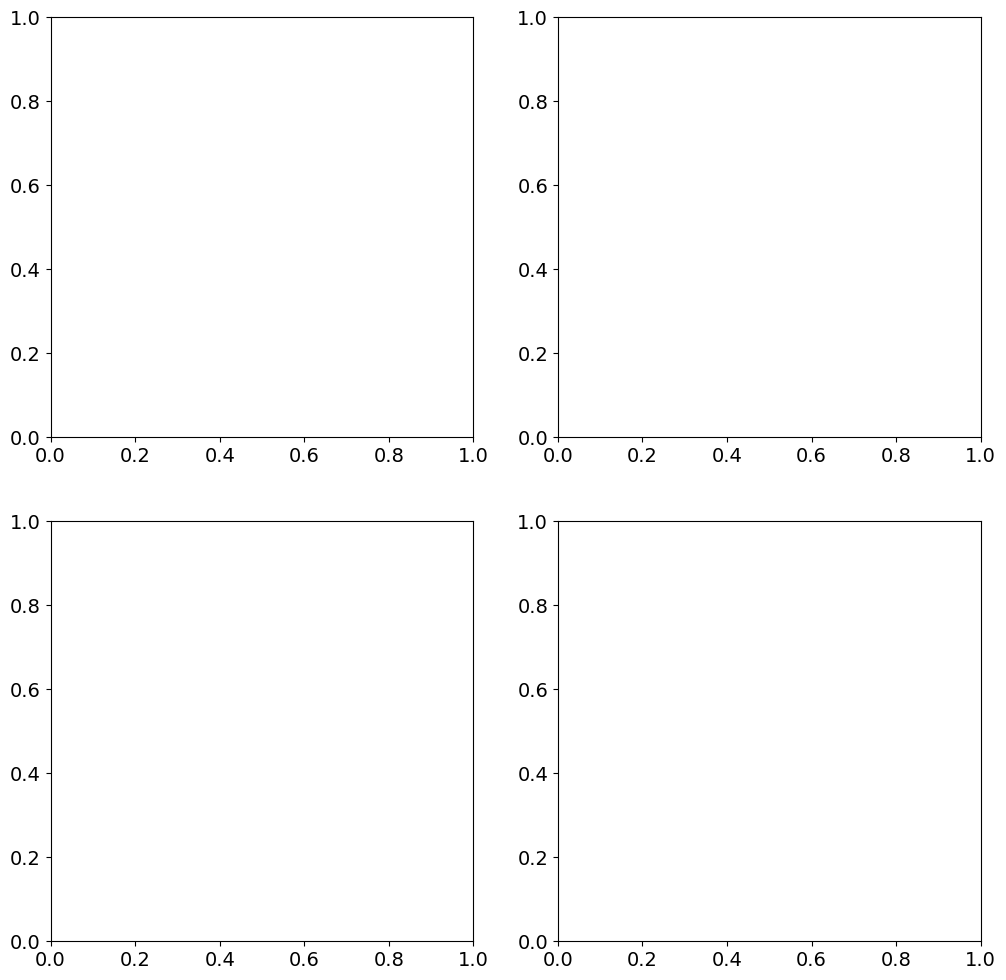

In [11]:
df_preds = pd.read_csv('preds.csv')

bnn_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Stochastic Output BNN (Flipout)', 'y_test_pred'].tolist())
bnn_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Stochastic Output BNN (Flipout)', 'y_test_stddevs'].tolist())
mlp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP', 'y_test_pred'].tolist())
mlp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP', 'y_test_stddevs'].tolist())
gp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'GP (RBF, sparse)', 'y_test_pred'].tolist())
gp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'GP (RBF, sparse)', 'y_test_stddevs'].tolist())
ft_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Fine-tuned', 'y_test_pred'].tolist())
ft_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Fine-tuned', 'y_test_stddevs'].tolist())

y_test_pred_list = [gp_pred,
                    bnn_pred,
                    mlp_pred,
                    ft_pred]

y_test_std_list = [gp_stddevs,
                    bnn_stddevs,
                    mlp_stddevs,
                    ft_stddevs]

y_test_list = [y_test,
                y_test,
                y_test,
                y_test]

print(len(y_test_list[0]))

titles = ["GP (RBF, sparse)",
            "BNN",
            "Prob. MLP",
            "Prob. MLP (via fine-tuning)"]

plot_confidence_interval_bar_grid(y_test_pred_list, y_test_std_list, y_test_list, bins=20, rmses=None, titles=titles) 

In [3]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
import tensorflow_probability as tfp
from sklearn.preprocessing import StandardScaler
from joblib import load


if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/FYP/UK Wind Turbines"

df = pd.read_pickle(open(DATA_PATH + '/cleaned_data.pkl','rb'))

In [12]:
df = df[df['turbine'] == TURBINE_ID]
df = df.dropna(subset=FEATURES + [OUTPUT_FEATURE] + [DATETIME_COL])
df.reset_index(drop=True, inplace=True)


In [13]:
def get_live_data(df, start_index=-144, end_index=None):
    df_live = df[start_index:end_index]

    X_live, y_live = df_live[FEATURES].to_numpy(), df_live[OUTPUT_FEATURE].to_numpy()

    scaler = load('saved_models/scaler.joblib')
    X_live = scaler.transform(X_live)
    X_live.shape
    return X_live, y_live

In [14]:
X_live, y_live = get_live_data(df, start_index=-144)

In [15]:
def generic_model(X_train_full):
    inputs = Input(shape=(X_train_full.shape[1],))
    hidden1 = Dense(300, activation="relu")(inputs)
    hidden2 = Dense(200, activation="relu")(hidden1)
    hidden3 = Dense(100, activation="relu")(hidden2)

    params = Dense(2)(hidden3)

    dist = tfp.layers.DistributionLambda(normal_softplus)(params)

    model = Model(inputs=inputs, outputs=dist)
    model.compile(Adam(learning_rate=0.001), loss=NLL)

    return model

# Train the initial model using X_full with the checkpoint callback
generic_model = generic_model(X_live)
generic_model.summary()
generic_model.load_weights('saved_models/pretrain.h5')
evaluation = generic_model.evaluate(X_live, y_live)

def create_model_finetune(X_train, generic_model, seed):
    keras.utils.set_random_seed(seed)

    inputs = Input(shape=(X_train.shape[1],))

    # Step 1: Load the architecture and weights of the previously trained model
    pretrained_model_layers = generic_model.layers[1:]
    l = inputs

    for layer in pretrained_model_layers:
        layer.trainable = True
        l = layer(l)

    model_mlp_gaussian = Model(inputs=inputs, outputs=l)
    model_mlp_gaussian.compile(Adam(learning_rate=1e-4), loss=NLL)

    return model_mlp_gaussian

model_finetune = create_model_finetune(X_live, generic_model, 42)
model_finetune.summary()

model_finetune.load_weights('saved_models/finetuned.keras')
evaluation = model_finetune.evaluate(X_live, y_live)
print("Evaluation Loss:", evaluation)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense (Dense)               (None, 300)               10500     
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                            

In [16]:
y_live_pred = np.array(model_finetune(X_live).mean()).ravel()

y_live_stddevs = np.array(model_finetune(X_live).stddev()).ravel()

save_preds(None, y_live_pred, y_live_stddevs)

evaluate_and_save_metrics(None,
    y_live, y_live, y_live_pred, y_live_pred,
    y_live_stddevs, y_live_stddevs, 0.99)

Train RMSE: 22.594
Test RMSE: 22.594
Train MAE: 10.935
Test MAE: 10.935
97.92%
97.92%


In [27]:
import ipywidgets as widgets
from IPython.display import display, clear_output


def interactive_qq_plot_with_widgets(df, FEATURES, OUTPUT_FEATURE):
    # Create widgets for start and end indices
    start_index_widget = widgets.IntText(value=-144, description='Start Index:', continuous_update=False)
    end_index_widget = widgets.IntText(value=None, description='End Index:', continuous_update=False)
    ci_widget = widgets.FloatSlider(value=0.99, min=0.90, max=0.999, step=0.001, description='Confidence Interval:', continuous_update=False)
    
    def update_plot(start_index, end_index, ci):
        # Clear previous output
        clear_output(wait=True)
        
        # Retrieve live data
        print(start_index, end_index)
        X_live, y_live = get_live_data(df, start_index, end_index)
        
        # Mock predictions and predicted_std for demonstration
        predictions = np.mean(X_live, axis=1)  # Replace with your model's predictions
        predicted_std = np.std(X_live, axis=1)  # Replace with your model's predicted std
        
        normalized_residuals = (y_live - predictions) / predicted_std
        
        # Plot
        customized_qq_plot(normalized_residuals, ci)
        
    interact_manual = widgets.interactive(update_plot, start_index=start_index_widget, end_index=end_index_widget, ci=ci_widget)
    
    display(interact_manual)

interactive_qq_plot_with_widgets(df, FEATURES, OUTPUT_FEATURE)


interactive(children=(IntText(value=-144, description='Start Index:'), IntText(value=0, description='End Index…

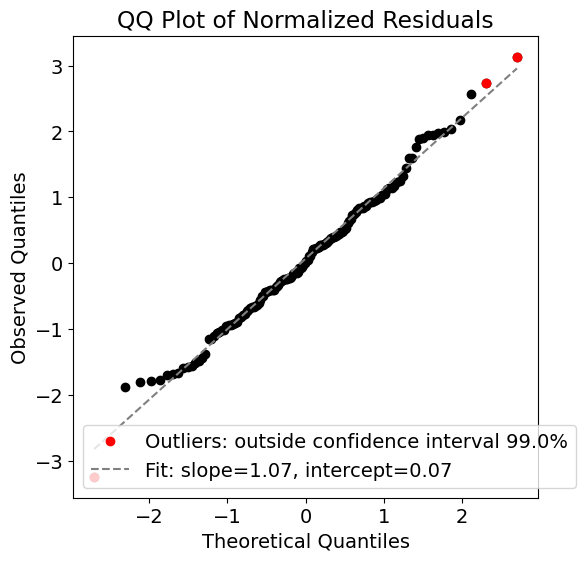

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def customized_qq_plot(normalized_residuals, ci=0.99):
    """
    Generates a QQ plot of normalized residuals with specific points marked in a different color.
    
    Parameters:
    - normalized_residuals: Array of normalized residuals.
    - out_of_confidence_indices: Indices of residuals to be highlighted in a different color.
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    z_value = stats.norm.ppf((1 + ci) / 2)

    # Calculate theoretical quantiles and observed quantiles
    theoretical_quantiles = stats.norm.ppf(np.linspace(0.5/len(normalized_residuals), 1-0.5/len(normalized_residuals), len(normalized_residuals)))
    observed_quantiles = np.sort(normalized_residuals)
    lower_bound = 0 - z_value 
    upper_bound = 0 + z_value
    out_of_confidence_indices = np.where(~np.logical_and(observed_quantiles >= lower_bound, observed_quantiles <= upper_bound))[0]

    # Plot all points
    ax.plot(theoretical_quantiles, observed_quantiles, 'o', color='black')

    # Highlight specific points in a different color
    ax.plot(theoretical_quantiles[out_of_confidence_indices], observed_quantiles[out_of_confidence_indices], 'o', color='red', label=f'Outliers: outside confidence interval {ci*100:.1f}%')

    # Plot the line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(theoretical_quantiles, observed_quantiles)
    line = slope * theoretical_quantiles + intercept
    ax.plot(theoretical_quantiles, line, color='gray', linestyle='--', label=f'Fit: slope={slope:.2f}, intercept={intercept:.2f}')

    
    ax.set_title('QQ Plot of Normalized Residuals')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Observed Quantiles')
    plt.legend()
    plt.show()

# Example usage
true_values = y_live
predictions = y_live_pred
predicted_std = y_live_stddevs

normalized_residuals = (true_values - predictions) / predicted_std
out_of_confidence_indices = [20, 40, 60]  # Example indices of points to highlight, for demonstration

customized_qq_plot(normalized_residuals)
